# Surface type distinction to get melt factor depending on snow age 

**a surface type distinction model is included with a bucket system together with a melt_f that varies with age** inside of `TIModel_Sfc_Type`:
- there are two options included at the moment:
    - `melt_f_update=annual`
        - If annual, then it uses 1 snow
            and 5 firn buckets with yearly melt factor updates.
    - `melt_f_update=monthly`:
        -  If monthly, each month the snow is ageing over 6 years (i.e., 72 months -> 72 buckets).
    - the ice bucket is thought as an "infinite" bucket (because we do not know the ice thickness at this model stage)
    - Melt factors are interpolated either:
        - linearly inbetween the buckets.
        - or using a negativ exponential change assumption with an e-folding change assumption of e.g. 0.5 or 1 year
- default is to use a **spinup** of 6 years. So to compute the specific mass balance between 2000 and 2020, with `spinup=True`, the annual mb is computed since 1994 where at first everything is ice, and then it accumulates over the next years, so that in 2000 there is something in each bucket ...
    - if we start in 1979 (start of W5E5), we neglect the spinup because we don't have climate data before 1979

- the ratio of snow melt factor to ice melt factor is set to 0.5 (as in GloGEM) but it can be changed via `melt_f_ratio_snow_to_ice`
    - if we set `melt_f_ratio_snow_to_ice=1` the melt factor is equal for all buckets, hence the results are equal to no surface type distinction (as in `TIModel`)
- `get_annual_mb` and `get_monthly_mb` work as in PastMassBalance, however they only accept the height array that corresponds to the inversion height (so no mass-balance elevation feedback can be included at the moment!)
    - that means the given mass-balance ist the mass-balance over the inversion heights (before doing the inversion and so on)
- the buckets are automatically updated when using `get_annual_mb` or `get_monthly_mb` via the `TIModel_Sfc_Type.pd_bucket` dataframe 
- to make sure that we do not compute mass-balance twice and to always have a spin-up of 6 years, the mass balance is automatically saved under 
    - `get_annual_mb.pd_mb_annual`: for each year
        - when using `get_monthly_mb` for several years, after computing the December month, the `pd_mb_annual` dataframe is updated
    - `get_annual_mb.pd_mb_monthly`: for each month 
        - note that this stays empty if we only use get_annual_mb with annual melt_f_update

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import pickle
import ast

import matplotlib.pyplot as plt
import matplotlib

from numpy.testing import assert_allclose
import statsmodels as stats
import scipy

import scipy.stats as stats
from IPython.core.pylabtools import figsize
import os

import oggm
from oggm import cfg, utils, workflow, tasks, graphics, entity_task
from oggm.utils import date_to_floatyear
from oggm.shop import gcm_climate
from oggm.core import massbalance, flowline, climate

import logging
log = logging.getLogger(__name__)

cfg.initialize() #logging_level='WARNING'
cfg.PARAMS['use_multiprocessing'] = False
cfg.PARAMS['continue_on_error'] = False
cfg.PATHS['working_dir'] = utils.gettempdir(dirname='OGGM-sfc-type', reset=False)

# use Huss flowlines
base_url = ('https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.4/'
            'L1-L2_files/elev_bands')

# import the MBsandbox modules

from MBsandbox.mbmod_daily_oneflowline import (process_era5_daily_data, process_w5e5_data, TIModel,
                                               BASENAMES, MultipleFlowlineMassBalance_TIModel, TIModel_Sfc_Type)

from MBsandbox.help_func import minimize_bias_geodetic, optimize_std_quot_brentq_geod, minimize_winter_mb_brentq_geod_via_pf, calibrate_to_geodetic_bias_quot_std_different_temp_bias
from MBsandbox.help_func import calibrate_to_geodetic_bias_winter_mb

cfg.PARAMS['hydro_month_nh']=1
df = ['RGI60-11.01450']

gdirs = workflow.init_glacier_directories(df, from_prepro_level=2,
                                              prepro_border=10,
                                              prepro_base_url=base_url,
                                              prepro_rgi_version='62')
gdir = gdirs[0]

2022-04-28 15:54:29: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2022-04-28 15:54:29: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2022-04-28 15:54:29: oggm.cfg: Multiprocessing: using all available processors (N=8)
2022-04-28 15:54:29: oggm.cfg: PARAMS['hydro_month_nh'] changed from `10` to `1`.
2022-04-28 15:54:29: oggm.workflow: init_glacier_directories from prepro level 2 on 1 glaciers.
2022-04-28 15:54:29: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2022-04-28 15:54:29: oggm.utils: /home/lilianschuster/OGGM/download_cache/cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.4/L1-L2_files/elev_bands/RGI62/b_010/L2/RGI60-11/RGI60-11.01.tar verified successfully.


In [2]:
# get the geodetic data for calibration
pd_geodetic = utils.get_geodetic_mb_dataframe()
pd_geodetic = pd_geodetic.loc[pd_geodetic.period == '2000-01-01_2020-01-01']
mb_geodetic = pd_geodetic.loc[df].dmdtda.values * 1000
years = np.arange(2000, 2020, 1)


2022-04-28 15:54:30: oggm.utils: No known hash for cluster.klima.uni-bremen.de/~oggm/geodetic_ref_mb/hugonnet_2021_ds_rgi60_pergla_rates_10_20_worldwide_filled.hdf


In [3]:
# this is the resolution of the precipitation and temperature 
temporal_resol = 'monthly'
baseline_climate = 'W5E5' 

mb_type = 'mb_monthly'
gard_type = 'cte'
melt_f = 200
pf = 1.5

In [4]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
                                                  
process_w5e5_data(gdir, temporal_resol=temporal_resol,
                  climate_type=baseline_climate)
process_w5e5_data(gdir, temporal_resol='daily',
                  climate_type=baseline_climate)
h, w = gdir.get_inversion_flowline_hw()


2022-04-28 15:54:35: MBsandbox.mbmod_daily_oneflowline: (RGI60-11.01450) process_w5e5_data
2022-04-28 15:54:35: oggm.utils: No known hash for cluster.klima.uni-bremen.de/~lschuster/w5e5v2.0/flattened/daily/w5e5v2.0_tas_global_daily_flat_glaciers_1979_2019.nc
2022-04-28 15:54:35: oggm.utils: No known hash for cluster.klima.uni-bremen.de/~lschuster/w5e5v2.0/flattened/daily/w5e5v2.0_pr_global_daily_flat_glaciers_1979_2019.nc
2022-04-28 15:54:35: oggm.utils: No known hash for cluster.klima.uni-bremen.de/~lschuster/w5e5v2.0/flattened/daily/w5e5v2.0_glacier_invariant_flat.nc
2022-04-28 15:54:48: oggm.utils: /home/lilianschuster/OGGM/download_cache/cluster.klima.uni-bremen.de/~oggm/climate/era5/monthly/vdr/ERA5_lapserates_monthly.nc verified successfully.
2022-04-28 15:54:49: MBsandbox.mbmod_daily_oneflowline: (RGI60-11.01450) process_w5e5_data


In [5]:
fls = gdir.read_pickle('inversion_flowlines')

mb_mod_annual_1_a = TIModel_Sfc_Type(gdir, melt_f, mb_type=mb_type,
                                          melt_f_ratio_snow_to_ice=1, prcp_fac=pf,
                                          melt_f_update='annual',
                                          baseline_climate=baseline_climate)
melt_f_opt_1_a = scipy.optimize.brentq(minimize_bias_geodetic, 10, 1000,
                                             xtol=0.01, args=(mb_mod_annual_1_a,
                                                              mb_geodetic,
                                                              h, w, pf, False,
                                                              years,
                                                              False, True  # do spinup before
                                                              ), disp=True)
mb_mod_annual_1_a.melt_f = melt_f_opt_1_a

spec_1_a = mb_mod_annual_1_a.get_specific_mb(year=years, fls=fls) #, spinup=True)


# get an instance of a TIModel_Sfc_Type with annual update of the melt factor (this is sufficient for the app)
mb_mod_annual_0_5_a = TIModel_Sfc_Type(gdir, melt_f, mb_type=mb_type,
                                  melt_f_ratio_snow_to_ice=0.5, prcp_fac=pf,
                                    melt_f_update='annual',
                                  baseline_climate=baseline_climate
                                    )
melt_f_opt_0_5_a = scipy.optimize.brentq(minimize_bias_geodetic, 10, 1000,
                                      xtol=0.01, args=(mb_mod_annual_0_5_a,
                                                       mb_geodetic,
                                                       h, w, pf, False,
                                                       years,
                                                       False, True  # do spinup before
                                                       ), disp=True)
mb_mod_annual_0_5_a.melt_f = melt_f_opt_0_5_a
spec_0_5_a = mb_mod_annual_0_5_a.get_specific_mb(year=years, fls=fls) #, spinup=True)



# just for comparison: instance with no surface type distinction 
mb_mod_no_sfc_type = TIModel(gdir, melt_f, mb_type=mb_type,
                                     prcp_fac=pf, baseline_climate=baseline_climate)

melt_f_opt_no_sfc_type = scipy.optimize.brentq(minimize_bias_geodetic, 10, 1000,
                                      xtol=0.01, args=(mb_mod_no_sfc_type,
                                                       mb_geodetic,
                                                       h, w, pf, False,
                                                       years,
                                                       False, True  # do spinup before
                                                       ), disp=True)
mb_mod_no_sfc_type.melt_f = melt_f_opt_no_sfc_type


spec_no_sfc_type = mb_mod_no_sfc_type.get_specific_mb(year=years, fls=fls)



In [6]:
# with normal spinup for 5 years
mb_mod_monthly_0_5_m = TIModel_Sfc_Type(gdir, melt_f, mb_type=mb_type,
                                          melt_f_ratio_snow_to_ice=0.5, prcp_fac=pf,
                                          melt_f_update='monthly',
                                          baseline_climate=baseline_climate)
melt_f_opt_0_5_m = scipy.optimize.brentq(minimize_bias_geodetic, 10, 1000,
                                     xtol=0.01, args=(mb_mod_monthly_0_5_m,
                                                      mb_geodetic,
                                                      h, w, pf, False,
                                                      years,
                                                      False, True, # do spinup before
                                                      ), disp=True)
mb_mod_monthly_0_5_m.melt_f = melt_f_opt_0_5_m
spec_0_5_m = mb_mod_monthly_0_5_m.get_specific_mb(year=years, fls=fls) #, spinup=True)
print(melt_f_opt_0_5_m)

465.6455985980747


Monthly MB is saved in TIModel_Sfc_Type instance:

In [7]:
# the first 6 years are the spinup
mb_mod_monthly_0_5_m.pd_mb_monthly


,1994.000000,1994.083333,1994.166667,1994.250000,1994.333333,1994.416667,1994.500000,1994.583333,1994.666667,1994.750000,...,2019.166667,2019.250000,2019.333333,2019.416667,2019.500000,2019.583333,2019.666667,2019.750000,2019.833333,2019.916667
distance_along_flowline,,,,,,,,,,,,,,,,,,,,,
0.0,2.473364e-07,8.378636e-08,7.873890e-08,1.613816e-07,2.168407e-07,9.723642e-08,8.631428e-08,1.395922e-07,1.473888e-07,6.999572e-08,...,1.464505e-07,1.930532e-07,1.763713e-07,9.582887e-08,8.275137e-08,1.182805e-07,7.588261e-08,1.742089e-07,2.128766e-07,1.572515e-07
274.0,2.473364e-07,8.378636e-08,7.873890e-08,1.613816e-07,2.168407e-07,9.723642e-08,3.602673e-08,1.395922e-07,1.473888e-07,6.999572e-08,...,1.464505e-07,1.930532e-07,1.763713e-07,9.582887e-08,7.504283e-08,1.182805e-07,7.588261e-08,1.742089e-07,2.128766e-07,1.572515e-07
548.0,2.473364e-07,8.378636e-08,7.873890e-08,1.613816e-07,2.168407e-07,9.723642e-08,-5.200074e-08,1.395922e-07,1.473888e-07,6.999572e-08,...,1.464505e-07,1.930532e-07,1.763713e-07,9.582887e-08,-1.132895e-08,1.182805e-07,7.588261e-08,1.742089e-07,2.128766e-07,1.572515e-07
822.0,2.473364e-07,8.378636e-08,7.873890e-08,1.613816e-07,2.168407e-07,9.723642e-08,-1.535159e-07,9.355100e-08,1.473888e-07,6.999572e-08,...,1.464505e-07,1.930532e-07,1.763713e-07,9.582887e-08,-1.110213e-07,5.939688e-08,7.588261e-08,1.742089e-07,2.128766e-07,1.572515e-07
1096.0,2.473364e-07,8.378636e-08,7.873890e-08,1.613816e-07,2.168407e-07,9.723642e-08,-2.174110e-07,1.137434e-08,1.473888e-07,6.999572e-08,...,1.464505e-07,1.930532e-07,1.763713e-07,5.747260e-08,-1.817379e-07,-1.830701e-08,7.588261e-08,1.742089e-07,2.128766e-07,1.572515e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17536.0,2.473364e-07,8.378636e-08,-7.756510e-08,1.613816e-07,-6.252919e-07,-1.718023e-06,-2.564577e-06,-2.288962e-06,-1.343964e-06,-6.352179e-07,...,1.464505e-07,-1.856159e-07,-3.258854e-07,-2.092115e-06,-2.505512e-06,-2.308650e-06,-1.678640e-06,-1.186456e-06,2.128766e-07,1.572515e-07
17810.0,2.473364e-07,8.378636e-08,-1.117641e-07,1.613816e-07,-7.037037e-07,-1.765679e-06,-2.612233e-06,-2.336617e-06,-1.391620e-06,-6.828734e-07,...,1.346705e-07,-2.176982e-07,-3.523924e-07,-2.199314e-06,-2.553167e-06,-2.356306e-06,-1.726295e-06,-1.234111e-06,2.128766e-07,1.572515e-07
18084.0,2.473364e-07,8.378636e-08,-1.538076e-07,1.317492e-07,-8.285833e-07,-1.824120e-06,-2.670674e-06,-2.395058e-06,-1.450061e-06,-7.413145e-07,...,8.371329e-08,-2.495324e-07,-4.449547e-07,-2.296609e-06,-2.611608e-06,-2.414747e-06,-1.784737e-06,-1.292552e-06,1.994736e-07,1.572515e-07


Also annual MB is saved in TIModel_Sfc_Type instance:

In [8]:
# the first 6 years are the spinup
mb_mod_monthly_0_5_m.pd_mb_annual


,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
distance_along_flowline,,,,,,,,,,,,,,,,,,,,,
0.0,1.311470e-07,1.691267e-07,1.332061e-07,1.153072e-07,1.192578e-07,1.774512e-07,1.366345e-07,1.493681e-07,1.723251e-07,1.012931e-07,...,1.288558e-07,1.124132e-07,1.477455e-07,1.344648e-07,1.336452e-07,1.111487e-07,1.324610e-07,1.342523e-07,1.322961e-07,1.404382e-07
274.0,1.269564e-07,1.691267e-07,1.332061e-07,1.153072e-07,1.192578e-07,1.774512e-07,1.366345e-07,1.493681e-07,1.723251e-07,9.650609e-08,...,1.288558e-07,1.124132e-07,1.477455e-07,1.338158e-07,1.336452e-07,1.037219e-07,1.324610e-07,1.342523e-07,1.286201e-07,1.397958e-07
548.0,1.196208e-07,1.635108e-07,1.332061e-07,1.153072e-07,1.192578e-07,1.774512e-07,1.366345e-07,1.493681e-07,1.723251e-07,8.993363e-08,...,1.235320e-07,1.124132e-07,1.477455e-07,1.265503e-07,1.336452e-07,9.067254e-08,1.324610e-07,1.332526e-07,1.139515e-07,1.325981e-07
822.0,1.073244e-07,1.550652e-07,1.332061e-07,1.131155e-07,1.192578e-07,1.774512e-07,1.366345e-07,1.472019e-07,1.723251e-07,7.402382e-08,...,1.134391e-07,1.115191e-07,1.381345e-07,1.181631e-07,1.336452e-07,7.572212e-08,1.276676e-07,1.154822e-07,9.657634e-08,1.193835e-07
1096.0,9.515177e-08,1.491312e-07,1.332061e-07,1.069512e-07,1.185603e-07,1.767672e-07,1.332012e-07,1.411081e-07,1.714628e-07,6.309855e-08,...,1.063301e-07,1.055903e-07,1.311035e-07,1.091339e-07,1.336452e-07,6.512209e-08,1.156778e-07,9.624495e-08,8.427384e-08,1.038187e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17536.0,-7.454527e-07,-5.715585e-07,-5.716105e-07,-6.496757e-07,-6.666222e-07,-6.257206e-07,-7.040722e-07,-6.217812e-07,-6.560669e-07,-7.616278e-07,...,-6.611565e-07,-8.014676e-07,-7.152652e-07,-7.119315e-07,-7.863246e-07,-8.374012e-07,-7.375044e-07,-8.040278e-07,-8.862524e-07,-7.928327e-07
17810.0,-7.798867e-07,-6.028730e-07,-6.007684e-07,-6.852208e-07,-6.978792e-07,-6.574056e-07,-7.337451e-07,-6.465160e-07,-6.918261e-07,-8.042065e-07,...,-6.907329e-07,-8.337027e-07,-7.551577e-07,-7.455571e-07,-8.269060e-07,-8.744942e-07,-7.701318e-07,-8.427155e-07,-9.192419e-07,-8.235153e-07
18084.0,-8.254869e-07,-6.412747e-07,-6.365254e-07,-7.288629e-07,-7.363674e-07,-6.962653e-07,-7.728125e-07,-6.858996e-07,-7.376369e-07,-8.597377e-07,...,-7.248673e-07,-8.732333e-07,-8.055321e-07,-7.823805e-07,-8.724895e-07,-9.201823e-07,-8.075093e-07,-8.901631e-07,-9.596977e-07,-8.668333e-07


Buckets when using monthly melt_f_update:

In [9]:
# this is the output after the update (and before the next month)
# hence: the "youngest" bucket 0 is 0 
mb_mod_monthly_0_5_m.pd_bucket 

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,delta_kg/m2
distance_along_flowline,,,,,,,,,,,,,,,,,,,,,
0.0,0.0,371.931267,503.495773,412.03894,179.477554,279.756958,195.723541,226.654449,417.153488,456.609375,...,235.38295,139.49334,367.419159,539.760818,196.309341,383.945869,273.796967,190.740486,392.360138,NaN
274.0,0.0,371.931267,503.495773,412.03894,179.477554,279.756958,177.491296,226.654449,417.153488,456.609375,...,235.38295,139.49334,367.419159,539.760818,196.309341,383.945869,273.796967,190.740486,392.360138,NaN
548.0,0.0,371.931267,503.495773,412.03894,179.477554,279.756958,0.000000,199.859220,417.153488,456.609375,...,235.38295,139.49334,367.419159,539.760818,196.309341,383.945869,273.796967,190.740486,392.360138,NaN
822.0,0.0,371.931267,503.495773,412.03894,179.477554,140.485506,0.000000,0.000000,381.220475,456.609375,...,235.38295,139.49334,367.419159,539.760818,196.309341,383.945869,273.796967,190.740486,392.360138,NaN
1096.0,0.0,371.931267,503.495773,412.03894,179.477554,0.000000,0.000000,0.000000,79.941429,456.609375,...,235.38295,139.49334,367.419159,539.760818,196.309341,383.945869,273.796967,190.740486,392.360138,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17536.0,0.0,371.931267,503.495773,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
17810.0,0.0,371.931267,503.495773,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
18084.0,0.0,371.931267,471.794918,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN


Buckets when using annual melt_f_update and just 6 buckets:

In [10]:
mb_mod_annual_0_5_a.pd_bucket

,snow,firn_yr_1,firn_yr_2,firn_yr_3,firn_yr_4,firn_yr_5,delta_kg/m2
distance_along_flowline,,,,,,,
0.0,0.0,3985.971920,3754.882038,3810.402512,3759.562463,3150.552404,NaN
274.0,0.0,3967.378057,3648.512251,3810.402512,3759.562463,2939.934062,NaN
548.0,0.0,3759.414052,3225.756060,3781.556379,3759.562463,2566.367103,NaN
822.0,0.0,3381.005291,2744.611999,3268.341015,3621.063195,2148.037364,NaN
1096.0,0.0,2938.575900,2409.736952,2722.302716,3275.239991,1856.880926,NaN
...,...,...,...,...,...,...,...
17536.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
17810.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
18084.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,NaN


### Non-linear change of melt factor ?!
- do we have any literature of how melt factor changes for different albedo, is it a linear relation??? 
- Ice is less reflective than snow, ice melts more per positive degree day than snow: But how does this relation change over time for different "firn" stages???
 **need to find a relation of albedo vs snow age**-> if this is logarithmic we can say that DDF factor also decreases in a logarithmic way?!
 
			-  COSIPY, Sauter 2020: fresh snow albedo $\alpha_s$=0.9; firn albedo $\alpha_f$=0.55; ice albedo $\alpha_i$=0.3
				-   αsnow = αf + (αs − αf) exp (-s/t_albedo)
				-  The albedo timescale τ_albedo specifies how fast the snow albedo drops from fresh snow to firn. The number of days after the last snowfall is given by parameter s. Besides the temporal change, the overall snowpack thickness impacts the albedo. If the thickness of the snowpack d is thin, the albedo must tend towards the albedo of ice αi. If one introduces a charac- teristic snow depth scale d_star (e-folding), the full albedo can be written as:
					-  α = αsnow + (αi − αsnow) exp (-d/d_star)
				-  The model resets the albedo to fresh snow, if the snow accumulation exceeds a certain threshold (default value is 0.01 m) within one time step. This approach neglects sudden short-term jumps in albedo, which can occur when thin fresh snow layers quickly melt away. To account for this effect, the age of the underlying snow is also tracked. If the fresh snow layer melts faster than τ_albedo, the age of the snow cover is reset to the value of the underlying snow (Gurgiser et al., 2013)

In [11]:
### monthly melt_f_update
# with normal spinup for 6 years tau = 0.5
mb_mod_monthly_0_5_m_neg_exp = TIModel_Sfc_Type(gdir, melt_f, mb_type=mb_type,
                                          melt_f_ratio_snow_to_ice=0.5, prcp_fac=pf,
                                          melt_f_update='monthly',
                                          melt_f_change = 'neg_exp', 
                                          tau_e_fold_yr = 0.5, # default
                                          baseline_climate=baseline_climate)

melt_f_opt_0_5_m_neg_exp = scipy.optimize.brentq(minimize_bias_geodetic, 1, 1000,
                                     xtol=0.01, args=(mb_mod_monthly_0_5_m_neg_exp,
                                                      mb_geodetic,
                                                      h, w, pf, False,
                                                      years,
                                                      False, True, # do spinup before
                                                      ), disp=True)

mb_mod_monthly_0_5_m_neg_exp.melt_f = melt_f_opt_0_5_m_neg_exp
spec_0_5_m_neg_exp = mb_mod_monthly_0_5_m_neg_exp.get_specific_mb(year=years, fls=fls) #, spinup=True)
print('monthly melt_f_opt:')
print(melt_f_opt_0_5_m_neg_exp)

# with normal spinup for 6 years tau = 1yr
mb_mod_monthly_0_5_m_neg_exp_tau1yr = TIModel_Sfc_Type(gdir, melt_f, mb_type=mb_type,
                                          melt_f_ratio_snow_to_ice=0.5, prcp_fac=pf,
                                          melt_f_update='monthly',
                                          melt_f_change = 'neg_exp', 
                                          tau_e_fold_yr = 1, # default
                                          baseline_climate=baseline_climate)

melt_f_opt_0_5_m_neg_exp_tau1yr = scipy.optimize.brentq(minimize_bias_geodetic, 1, 1000,
                                     xtol=0.01, args=(mb_mod_monthly_0_5_m_neg_exp_tau1yr,
                                                      mb_geodetic,
                                                      h, w, pf, False,
                                                      years,
                                                      False, True, # do spinup before
                                                      ), disp=True)

mb_mod_monthly_0_5_m_neg_exp_tau1yr.melt_f = melt_f_opt_0_5_m_neg_exp_tau1yr
spec_0_5_m_neg_exp_tau1yr = mb_mod_monthly_0_5_m_neg_exp_tau1yr.get_specific_mb(year=years, fls=fls) #, spinup=True)
print(melt_f_opt_0_5_m_neg_exp_tau1yr)



# annual melt_f_update:
# with normal spinup for 5 years
print('annual melt_f_opt:')

mb_mod_annual_0_5_a_neg_exp = TIModel_Sfc_Type(gdir, melt_f, mb_type=mb_type,
                                          melt_f_ratio_snow_to_ice=0.5, prcp_fac=pf,
                                          melt_f_update='annual',
                                          melt_f_change = 'neg_exp', 
                                          tau_e_fold_yr = 0.5, # default
                                          baseline_climate=baseline_climate)

melt_f_opt_0_5_a_neg_exp = scipy.optimize.brentq(minimize_bias_geodetic, 1, 1000,
                                     xtol=0.01, args=(mb_mod_annual_0_5_a_neg_exp,
                                                      mb_geodetic,
                                                      h, w, pf, False,
                                                      years,
                                                      False, True, # do spinup before
                                                      ), disp=True)
mb_mod_annual_0_5_a_neg_exp.melt_f = melt_f_opt_0_5_a_neg_exp
spec_0_5_a_neg_exp = mb_mod_annual_0_5_a_neg_exp.get_specific_mb(year=years, fls=fls) #, spinup=True)

print(melt_f_opt_0_5_a_neg_exp)


# with normal spinup for 5 years
mb_mod_annual_0_5_a_neg_exp_tau1yr = TIModel_Sfc_Type(gdir, melt_f, mb_type=mb_type,
                                          melt_f_ratio_snow_to_ice=0.5, prcp_fac=pf,
                                          melt_f_update='annual',
                                          melt_f_change = 'neg_exp', 
                                          tau_e_fold_yr = 1, # default
                                          baseline_climate=baseline_climate)

melt_f_opt_0_5_a_neg_exp_tau1yr = scipy.optimize.brentq(minimize_bias_geodetic, 1, 1000,
                                     xtol=0.01, args=(mb_mod_annual_0_5_a_neg_exp_tau1yr,
                                                      mb_geodetic,
                                                      h, w, pf, False,
                                                      years,
                                                      False, True, # do spinup before
                                                      ), disp=True)
mb_mod_annual_0_5_a_neg_exp_tau1yr.melt_f = melt_f_opt_0_5_a_neg_exp_tau1yr
spec_0_5_a_neg_exp_tau1yr = mb_mod_annual_0_5_a_neg_exp_tau1yr.get_specific_mb(year=years, fls=fls) #, spinup=True)
print(melt_f_opt_0_5_a_neg_exp_tau1yr)

assert_allclose(spec_0_5_a_neg_exp.mean(), spec_0_5_a_neg_exp_tau1yr.mean(),rtol=1e-5)

monthly melt_f_opt:
404.61009108039036
427.59990384549127
annual melt_f_opt:
477.13458728277374
477.8505084267989


**Example plot with monthly melt_f update:**

In [12]:
for mb, name in zip([mb_mod_monthly_0_5_m_neg_exp_tau1yr, mb_mod_monthly_0_5_m_neg_exp, mb_mod_monthly_0_5_m, mb_mod_annual_0_5_a_neg_exp,
                     mb_mod_annual_0_5_a_neg_exp_tau1yr, mb_mod_annual_0_5_a, mb_mod_annual_1_a],
                    ['0_5_m_neg_exp_tau1yr', '0_5_m_neg_exp', '0_5_m', '0_5_a_neg_exp_tau1yr', '0_5_a_neg_exp','0_5_a', '1_a']):
    mb.get_specific_mb(year=years, fls=fls)

mb_grad_dict = {}
mb_annual_dict = {}
for mb, name in zip([mb_mod_monthly_0_5_m_neg_exp_tau1yr, mb_mod_monthly_0_5_m_neg_exp, mb_mod_monthly_0_5_m, mb_mod_annual_0_5_a_neg_exp,
                     mb_mod_annual_0_5_a_neg_exp_tau1yr, mb_mod_annual_0_5_a, mb_mod_annual_1_a],
                    ['0_5_m_neg_exp_tau1yr', '0_5_m_neg_exp', '0_5_m', '0_5_a_neg_exp_tau1yr', '0_5_a_neg_exp','0_5_a', '1_a']):
    mb_grad_dict_name = []
    mb_annual_dict_name = {}
    for y in years:
        mb_y = mb.pd_mb_annual[y]
        mb_gradient,_,_,_,_ = scipy.stats.linregress(h[mb_y<0], y=mb_y[mb_y<0]) 
        mb_grad_dict_name.append(mb_gradient)
        mb_annual_dict_name[y] = mb_y
    mb_grad_dict[name] = np.array(mb_grad_dict_name)
    mb_annual_dict[name] = mb_annual_dict_name

    
mb_grad_dict_m = {}
mb_monthly_dict = {}
bucket = {}
k=1
for mb, name in zip([mb_mod_monthly_0_5_m_neg_exp_tau1yr, mb_mod_monthly_0_5_m_neg_exp, mb_mod_monthly_0_5_m, mb_mod_annual_0_5_a_neg_exp,
                     mb_mod_annual_0_5_a_neg_exp_tau1yr, mb_mod_annual_0_5_a, mb_mod_annual_1_a],
                    ['0_5_m_neg_exp_tau1yr', '0_5_m_neg_exp', '0_5_m', '0_5_a_neg_exp_tau1yr', '0_5_a_neg_exp','0_5_a', '1_a']):
    # need to reset otherwise I can't get the pd_buckets right!!!
    mb.reset_pd_mb_bucket()
    mb_grad_dict_name = []
    mb_monthly_dict_name = {}
    bucket_name = {}
    for y in years:
        for m in np.arange(1,13,1):
            floatyr = date_to_floatyear(y,m)
            #if name != '0_5_m':
            _, bucket_name[floatyr] = mb.get_monthly_mb(h, year=floatyr, bucket_output =True)
            mb_m = mb.pd_mb_monthly[floatyr]
            try:
                mb_gradient,_,_,_,_ = scipy.stats.linregress(h[mb_m<0], y=mb_m[mb_m<0]) 
            except:
                mb_gradient = np.NaN
            mb_grad_dict_name.append(mb_gradient)
            mb_monthly_dict_name[floatyr] = mb_m
    mb_grad_dict_m[name] = np.array(mb_grad_dict_name)
    mb_monthly_dict[name] = mb_monthly_dict_name
    bucket[name] = bucket_name



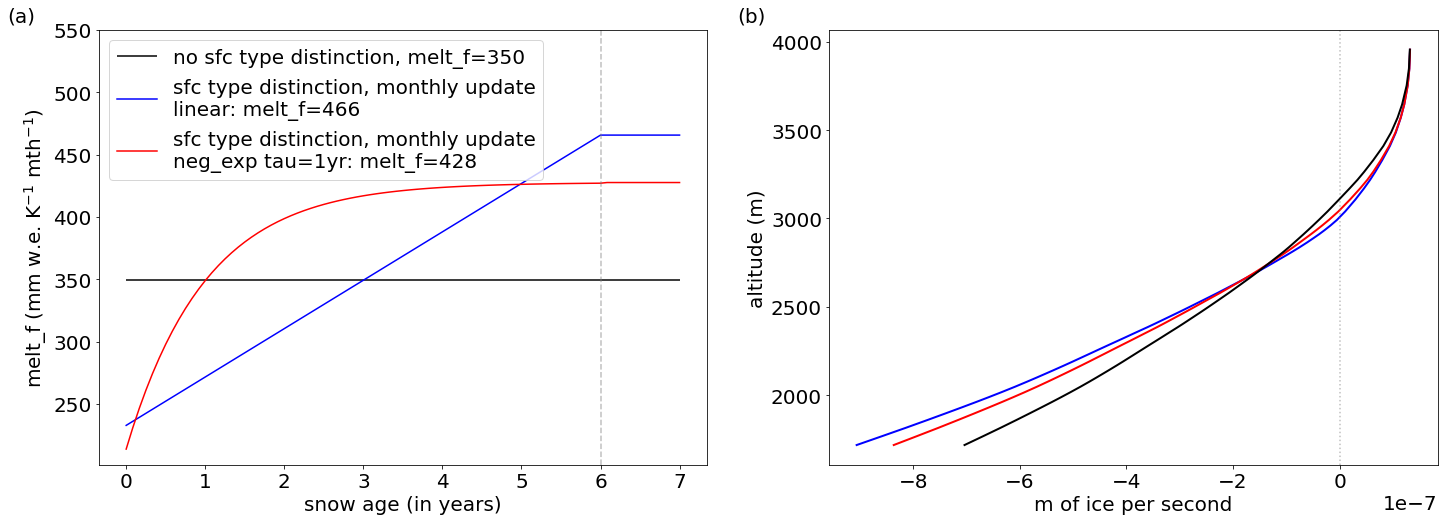

In [13]:
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(24, 8))
lw=2
plt.subplot(121)
ax = plt.gca()
plt.text(-0.15,1.02,'(a)', transform=ax.transAxes)
plt.hlines(xmin=0, xmax=7, y=mb_mod_annual_1_a.melt_f, color='black', label='no sfc type distinction, melt_f={:1.0f}'.format(melt_f_opt_1_a))


meltis = []
for _,m in mb_mod_monthly_0_5_m.melt_f_buckets.items():
    meltis.append(m)
for m in np.arange(0,12):
    meltis.append(mb_mod_monthly_0_5_m.melt_f)
# plt.plot(np.arange(0,7.01,1/12), meltis, color='blue', label='sfc type distinction, monthly update\nlinear change, melt_f={:0.1f}'.format(melt_f_opt_0_5_m))
plt.plot(np.arange(0,7.01,1/12), meltis, color='blue', label='sfc type distinction, monthly update\nlinear: melt_f={:1.0f}'.format(melt_f_opt_0_5_m))

#########
meltis = []
for _,m in mb_mod_monthly_0_5_m_neg_exp_tau1yr.melt_f_buckets.items():
    meltis.append(m)
for m in np.arange(0,12):
    meltis.append(mb_mod_monthly_0_5_m_neg_exp_tau1yr.melt_f)
    
plt.plot(np.arange(0,7.01,1/12), meltis, color='red', label='sfc type distinction, monthly update\nneg_exp tau=1yr: melt_f={:1.0f}'.format(melt_f_opt_0_5_m_neg_exp_tau1yr))
# plt.plot(np.arange(0,7.01,1/12), meltis, color='red', label='sfc type distinction, monthly update\nexp. change (tau=1yr), melt_f={:0.1f}'.format(melt_f_opt_0_5_m_neg_exp_tau1yr))
plt.xticks(np.arange(0,7.1,1))


plt.xlabel('snow age (in years)')
plt.yticks([250,300,350,400,450,500,550])
plt.ylabel(r'melt_f (mm w.e. K$^{-1}$ mth$^{-1}$)')

handles, labels = ax.get_legend_handles_labels()
# sort both labels and handles by labels
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
ax.legend(handles, labels)
plt.axvline(6, color='grey', ls='--', alpha=0.5)


plt.subplot(122)
ax = plt.gca()
plt.text(-0.15,1.02,'(b)', transform=ax.transAxes)
plt.plot(pd.DataFrame(mb_annual_dict['0_5_m']).mean(axis=1).values,
         h, color = 'blue', 
         lw=lw)

plt.plot(pd.DataFrame(mb_annual_dict['0_5_m_neg_exp_tau1yr']).mean(axis=1).values,
         h, color = 'red', 
         lw=lw)
plt.axvline(0, color='grey', ls=':', alpha=0.5)


#plt.plot(pd.DataFrame(mb_annual_dict['0_5_a']).mean(axis=1).values,
#         h, label='ratio=0.5 annual update\n(melt_f: {:0.1f})'.format(melt_f_opt_0_5_a), color='cyan',
#         lw=lw)
plt.plot(pd.DataFrame(mb_annual_dict['1_a']).mean(axis=1).values,
         h, color='black',
         lw=lw)
plt.xlabel('m of ice per second')
plt.ylabel('altitude (m)')
#plt.title('mean annual MB profile of Hintereisferner')
plt.savefig('mb_profile_aletsch.pdf')
#plt.savefig('mb_profile_aletsch.png')

## Minimize both geodetic bias and winter MB using melt_f and prcp-fac as parameters to calibrate:
- use the `help_func/minimize_winter_mb_brentq_geod_via_pf` function and the `help_func/calibrate_to_geodetic_bias_winter_mb` function

In [14]:
df = ['RGI60-11.00897', 'RGI60-11.01450']

gdirs = workflow.init_glacier_directories(df, from_prepro_level=2,
                                              prepro_border=10,
                                              prepro_base_url=base_url,
                                              prepro_rgi_version='62')
# get the geodetic data for calibration
for gdir in gdirs:
    process_w5e5_data(gdir, temporal_resol=temporal_resol,
                      climate_type=baseline_climate)
    process_w5e5_data(gdir, temporal_resol='daily',
                      climate_type=baseline_climate)

2022-03-07 08:14:38: oggm.workflow: init_glacier_directories from prepro level 2 on 2 glaciers.
2022-03-07 08:14:38: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 2 glaciers
2022-03-07 08:14:38: oggm.utils: /home/lilianschuster/OGGM/download_cache/cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.4/L1-L2_files/elev_bands/RGI62/b_010/L2/RGI60-11/RGI60-11.00.tar verified successfully.
2022-03-07 08:14:38: MBsandbox.mbmod_daily_oneflowline: (RGI60-11.00897) process_w5e5_data
2022-03-07 08:14:40: MBsandbox.mbmod_daily_oneflowline: (RGI60-11.00897) process_w5e5_data
2022-03-07 08:14:41: MBsandbox.mbmod_daily_oneflowline: (RGI60-11.01450) process_w5e5_data
2022-03-07 08:14:42: MBsandbox.mbmod_daily_oneflowline: (RGI60-11.01450) process_w5e5_data


In [13]:
out = calibrate_to_geodetic_bias_winter_mb(gdirs[0], method = 'pre-check', temp_bias = 0, mb_type = 'mb_pseudo_daily')


In [ ]:
import time
start = time.time()

# takes a bit long -> will be optimised later!
method = 'pre-check' 
j = 0
pd_calib = pd.DataFrame(np.NaN, index=np.arange(0, int(len(np.arange(-4,4.1,0.5))*len(gdirs))),
                        columns=['rgi_id', 'temp_bias', 'pf_opt', 'melt_f',
                                 'winter_prcp_mean', 'winter_solid_prcp_mean',
                                 'specific_melt_winter_kg_m2', 'except_necessary', 'quot_std', 'mae_mb_profile'])
for gdir in [gdirs[13:14]]: # here just two glaciers
    for temp_bias in np.arange(-4,4.1,0.5):
        pd_calib.iloc[j] = np.NaN

        try:
            out = calibrate_to_geodetic_bias_winter_mb(gdir, method = method, temp_bias = temp_bias, mb_type = 'mb_real_daily')
            (pd_calib.loc[j,'pf_opt'], pd_calib.loc[j,'melt_f'],
             pd_calib.loc[j, 'winter_prcp_mean'], pd_calib.loc[j, 'winter_solid_prcp_mean'],
             pd_calib.loc[j, 'specific_melt_winter_kg_m2'], pd_calib.loc[j,'except_necessary'], 
             pd_calib.loc[j, 'quot_std'], pd_calib.loc[j, 'mae_mb_profile']) = out
        except:
            pass
        pd_calib.loc[j, 'rgi_id'] = gdir.rgi_id
        pd_calib.loc[j, 'temp_bias'] = temp_bias
        j += 1
    #except:
    #pass
#pd_calib['rgi_id'] = gdir.rgi_id
pd_calib['winter_prcp_mean_no_pf'] = pd_calib['winter_prcp_mean']/pd_calib['pf_opt']
pd_calib['winter_solid_prcp_mean_no_pf'] = pd_calib['winter_solid_prcp_mean']/pd_calib['pf_opt']
end = time.time()
print('execution time: {} minutes with method: {}'.format((end-start)/60, method))


In [66]:
pd_calib

,rgi_id,temp_bias,pf_opt,melt_f,winter_prcp_mean,winter_solid_prcp_mean,specific_melt_winter_kg_m2,except_necessary,quot_std,mae_mb_profile,winter_prcp_mean_no_pf,winter_solid_prcp_mean_no_pf
0,RGI60-11.00897,-4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,RGI60-11.00897,-3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,RGI60-11.00897,-3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,RGI60-11.00897,-2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,RGI60-11.00897,-2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,RGI60-11.00897,-1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,RGI60-11.00897,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,RGI60-11.00897,-0.5,3.285540,677.182375,1258.212309,1256.865197,3.461853,1.0,2.704031,1227.330339,382.954483,382.544470
8,RGI60-11.00897,0.0,3.309417,543.643984,1267.356078,1263.337564,8.037615,1.0,2.440342,1023.947193,382.954483,381.740216
9,RGI60-11.00897,0.5,3.349340,443.861807,1282.644909,1273.541188,14.674270,1.0,2.207430,848.745932,382.954483,380.236419


as presumed, the precipitation factor does not change much with different temp. biases because it is calibrated to match the winter MB which is independent of temp. bias in case of:
- no significant melt during winter months
- most precipitation is solid over winter months (even with temp. bias)
Melt during winter is relatively small and precipitation is almost equal to solid precipitation for the Aletsch glacier (for the applied temp. bias range

-> ok, in case of Aletsch glacier, we do not have a MB profile,  perfect combination to match quot_std would be:

In [67]:
pd_calib_aletsch = pd_calib.loc[pd_calib.rgi_id == 'RGI60-11.01450']
pd_calib_aletsch.iloc[np.argmin(np.absolute(pd_calib_aletsch['quot_std']-1))][['pf_opt', 'melt_f', 'temp_bias', 'quot_std']]

pf_opt         0.563005
melt_f       326.957375
temp_bias          -1.0
quot_std       1.006381
Name: 23, dtype: object

Hintereisferner:

In [68]:
pd_calib_hef = pd_calib.loc[pd_calib.rgi_id == 'RGI60-11.00897']
pd_calib_hef[['pf_opt', 'melt_f', 'temp_bias', 'quot_std', 'mae_mb_profile']]

,pf_opt,melt_f,temp_bias,quot_std,mae_mb_profile
0,NaN,NaN,-4.0,NaN,NaN
1,NaN,NaN,-3.5,NaN,NaN
2,NaN,NaN,-3.0,NaN,NaN
3,NaN,NaN,-2.5,NaN,NaN
4,NaN,NaN,-2.0,NaN,NaN
5,NaN,NaN,-1.5,NaN,NaN
6,NaN,NaN,-1.0,NaN,NaN
7,3.285540,677.182375,-0.5,2.704031,1227.330339
8,3.309417,543.643984,0.0,2.440342,1023.947193
9,3.349340,443.861807,0.5,2.207430,848.745932


HEF would need further fine tuning: 

In [72]:
temp_bias = 5.5 # (manual tuning done here ...  )
out = calibrate_to_geodetic_bias_winter_mb(gdirs[0], method = method, temp_bias = temp_bias)
out

(5.108841286578628,
 121.02403494045163,
 1956.4536718813472,
 1573.539350400227,
 188.1181860516788,
 0,
 1.3943390203094452,
 484.1256202888846)

-> this is quite a high temp. bias !!!

## ALl in workflow:

In [5]:
_, path = utils.get_wgms_files()
pd_mb_overview = pd.read_csv(path[:-len('/mbdata')] + '/mb_overview_seasonal_mb_time_periods_20220301.csv',
                                     index_col='Unnamed: 0')
seasonal_mb_candidates = pd_mb_overview.rgi_id.unique()
ref_candidates = seasonal_mb_candidates #oggm.utils.get_ref_mb_glaciers_candidates()

In [6]:
cfg.PARAMS['use_multiprocessing'] = True

2022-03-17 09:11:37: oggm.cfg: Multiprocessing switched ON after user settings.


In [7]:
cfg.PARAMS["hydro_month_nh"] = 1 
cfg.PARAMS["hydro_month_sh"] = 1 
reinit = False
if reinit:
    gdirs = workflow.init_glacier_directories(
                    ref_candidates,
                    from_prepro_level=2,
                    prepro_border=10,
                    prepro_base_url=base_url,
                    prepro_rgi_version='62')
    t=workflow.execute_entity_task(tasks.compute_downstream_line, gdirs)
    t=workflow.execute_entity_task(tasks.compute_downstream_bedshape, gdirs)
    #if baseline_climate == 'W5E5':
    #if mb_type != 'mb_monthly':
    climate_type = 'W5E5'
    t = workflow.execute_entity_task(process_w5e5_data, gdirs, climate_type=climate_type,
                                  temporal_resol='daily')
    t = workflow.execute_entity_task(process_w5e5_data, gdirs, climate_type=climate_type,
                                  temporal_resol='monthly')
else: 
    gdirs = workflow.init_glacier_directories(
                    ref_candidates)

2022-03-09 15:52:42: oggm.cfg: PARAMS['hydro_month_sh'] changed from `4` to `1`.
2022-03-09 15:52:42: oggm.workflow: Execute entity tasks [GlacierDirectory] on 99 glaciers
2022-03-09 15:55:40: MBsandbox.help_func: (RGI60-19.02059) calibrate_to_geodetic_bias_quot_std_different_temp_bias
2022-03-09 15:55:40: MBsandbox.help_func: (RGI60-17.02128) calibrate_to_geodetic_bias_quot_std_different_temp_bias
2022-03-09 15:55:40: MBsandbox.help_func: (RGI60-11.00002) calibrate_to_geodetic_bias_quot_std_different_temp_bias
2022-03-09 15:55:40: MBsandbox.help_func: (RGI60-11.00781) calibrate_to_geodetic_bias_quot_std_different_temp_bias
2022-03-09 15:55:40: MBsandbox.help_func: (RGI60-11.00897) calibrate_to_geodetic_bias_quot_std_different_temp_bias
2022-03-09 15:55:40: MBsandbox.help_func: (RGI60-19.02056) calibrate_to_geodetic_bias_quot_std_different_temp_bias
2022-03-09 15:55:40: MBsandbox.help_func: (RGI60-11.00251) calibrate_to_geodetic_bias_quot_std_different_temp_bias
2022-03-09 15:55:40: MB

In [9]:
import time
method = 'pre-check' 
sfc_type_distinction = True
start = time.time()
workflow.execute_entity_task(calibrate_to_geodetic_bias_quot_std_different_temp_bias, gdirs, sfc_type_distinction = sfc_type_distinction, temp_b_range=[0],
                                                       method = 'pre-check', pf_cte=2.9,
                             optimize_std_quot=False)
end = time.time()
print('execution time: {} minutes with method: {} and sfc type distinction {}'.format((end-start)/60, method, sfc_type_distinction))

2022-03-09 17:02:21: oggm.workflow: Execute entity tasks [calibrate_to_geodetic_bias_quot_std_different_temp_bias] on 99 glaciers


execution time: 54.84196821053823 minutes with method: pre-check and sfc type distinction True


In [10]:
import time
method = 'pre-check' 
sfc_type_distinction = True
start = time.time()
workflow.execute_entity_task(calibrate_to_geodetic_bias_quot_std_different_temp_bias, gdirs, sfc_type_distinction = sfc_type_distinction, temp_b_range=[0],
                                                       method = 'pre-check')
end = time.time()
print('execution time: {} minutes with method: {} and sfc type distinction {}'.format((end-start)/60, method, sfc_type_distinction))

2022-03-09 18:27:20: oggm.workflow: Execute entity tasks [calibrate_to_geodetic_bias_quot_std_different_temp_bias] on 99 glaciers


execution time: 305.3578599135081 minutes with method: pre-check and sfc type distinction True


In [ ]:
start = time.time()
workflow.execute_entity_task(calibrate_to_geodetic_bias_quot_std_different_temp_bias, gdirs,
                             sfc_type_distinction = sfc_type_distinction, temp_b_range=[0],
                             melt_f_update='annual', method = 'pre-check')
end = time.time()
print('execution time: {} minutes with method: {} and sfc type distinction {}'.format((end-start)/60, method, sfc_type_distinction))

In [51]:
import time
start = time.time()

# takes a bit long -> will be optimised later!
method = 'pre-check' 
temp_b_range = np.arange(-6, 6.1,6)
print(temp_b_range)
sfc_type_distinction = False
workflow.execute_entity_task(calibrate_to_geodetic_bias_winter_mb_different_temp_bias, [gdirs[5]],
                             #gdirs[:10],
                             temp_b_range = temp_b_range, 
                             method=method,# np.arange(-6,6.1,0.5)
                             sfc_type_distinction = sfc_type_distinction
                             )

end = time.time()
print('execution time: {} minutes with method: {} and sfc type distinction {}'.format((end-start)/60, method, sfc_type_distinction))

2022-03-07 16:40:42: oggm.workflow: Execute entity tasks [calibrate_to_geodetic_bias_winter_mb_different_temp_bias] on 1 glaciers
2022-03-07 16:40:42: __main__: (RGI60-11.00897) calibrate_to_geodetic_bias_winter_mb_different_temp_bias


[-6.  0.  6.]
execution time: 2.29971729516983 minutes with method: pre-check and sfc type distinction False


In [336]:
ts = []
for rgi_id in ref_candidates:
    try:
        f = pd.read_csv(f'/home/lilianschuster/Schreibtisch/PhD/bayes_2022/calib_winter_mb/test_run/calib_winter_mb_monthly_melt_f_update_{rgi_id}_methodpre-check.csv')
        ts.append(f)
    except:
        pass
pd_calib_sfc_type =pd.concat(ts, ignore_index = True)
#pd_calib_sfc_type = pd_calib_sfc_type[pd_calib_sfc_type.grad_type == 'cte']
#pd_calib_sfc_type = pd_calib_sfc_type[pd_calib_sfc_type.melt_f_change == 'linear']
pd_calib_sfc_type = pd_calib_sfc_type.dropna(subset=['pf_opt', 'melt_f'])


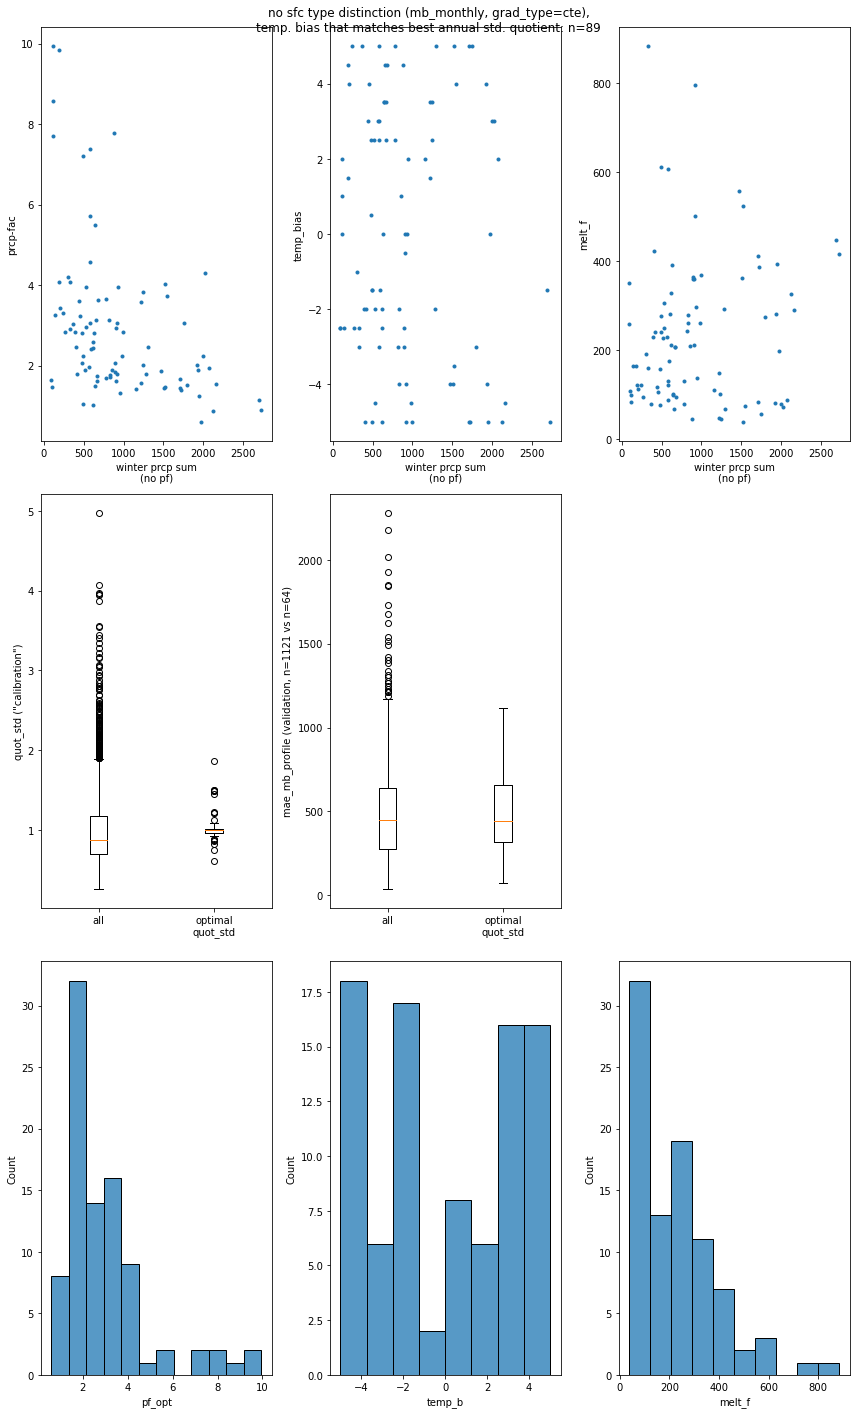

In [282]:
plt.figure(figsize=(12,20))
plt.suptitle(f'no sfc type distinction (mb_monthly, grad_type=cte),\ntemp. bias that matches best annual std. quotient: n={len(rgi_working)}')

plt.subplot(331)
plt.plot(pd_calib_opt_quot_std.winter_prcp_mean_no_pf,
         pd_calib_opt_quot_std.pf_opt, '.')
plt.xlabel('winter prcp sum\n(no pf)')
plt.ylabel('prcp-fac')

plt.subplot(332)
plt.plot(pd_calib_opt_quot_std.winter_prcp_mean_no_pf,
         pd_calib_opt_quot_std.temp_bias, '.')
plt.xlabel('winter prcp sum\n(no pf)')
plt.ylabel('temp_bias')

plt.subplot(333)
plt.plot(pd_calib_opt_quot_std.winter_prcp_mean_no_pf,
         pd_calib_opt_quot_std.melt_f, '.')
plt.xlabel('winter prcp sum\n(no pf)')
plt.ylabel('melt_f')

plt.subplot(334)
plt.boxplot([pd_calib.quot_std,
             pd_calib_opt_quot_std.quot_std])
plt.xticks(ticks=[1,2], labels=['all', 'optimal\nquot_std'])
plt.ylabel('quot_std ("calibration")')

plt.subplot(335)
plt.boxplot([pd_calib.mae_mb_profile.dropna(),
             pd_calib_opt_quot_std.mae_mb_profile])
plt.xticks(ticks=[1,2], labels=['all', 'optimal\nquot_std'])

plt.ylabel(f'mae_mb_profile (validation, n={working_mb_profile_len} vs n={working_mb_profile_len_opt_quot})')
import seaborn as sns
plt.subplot(337)
sns.histplot(pd_calib_opt_quot_std.pf_opt) #, kind = 'kde')
plt.xlabel('pf_opt')

plt.subplot(338)
sns.histplot(pd_calib_opt_quot_std.temp_bias)
plt.xlabel('temp_b')

plt.subplot(339)
sns.histplot(pd_calib_opt_quot_std.melt_f)
plt.xlabel('melt_f')
plt.tight_layout()

### for different MB model types

<Figure size 1728x1080 with 0 Axes>

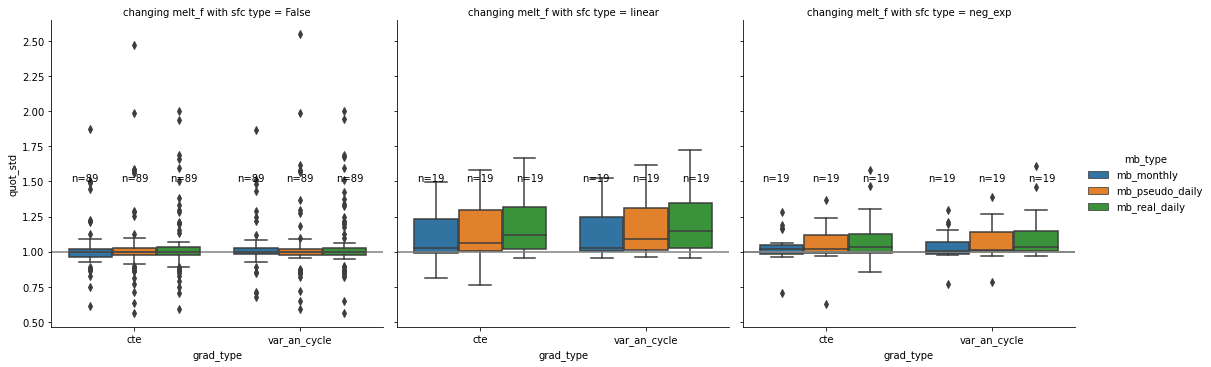

In [609]:
plt.figure(figsize=(24,15))
g = sns.catplot(y='quot_std', hue='mb_type', data = pd_calib_opt_quot_std, x = 'grad_type',
            kind = 'box', col='changing melt_f with sfc type')#, whis=False, fliersize=0)
plt.axhline([1], color = 'grey')
# ax = plt.gca()

for sfc_type in [False, 'linear', 'neg_exp']:

    pd_calib_opt_quot_std_pre_sel = pd_calib_opt_quot_std.loc[pd_calib_opt_quot_std['changing melt_f with sfc type'] == sfc_type]
    ax = g.axes_dict[sfc_type]
    ax.axhline([1], color = 'grey')
    #plt.ylim([0,2])
    # Calculate number of obs per group & median to position labels
    nobs = []
    medians = []
    for grad_type in ['cte', 'var_an_cycle']:
        pd_calib_opt_quot_std_sel_n = pd_calib_opt_quot_std_pre_sel.loc[pd_calib_opt_quot_std_pre_sel.grad_type ==grad_type]
        
        pd_calib_opt_quot_std_sel = pd_calib_opt_quot_std_sel_n.dropna(subset='quot_std')
        medians_k = pd_calib_opt_quot_std_sel.groupby(['mb_type'])['quot_std'].median().values
        nobs_k = pd_calib_opt_quot_std_sel['mb_type'].value_counts().values
        nobs_k = [str(x) for x in nobs_k.tolist()]
        nobs_k = ["n=" + i for i in nobs_k]
        medians.append(medians_k)
        nobs.append(nobs_k)
    medians = np.concatenate(medians)
    nobs = np.concatenate(nobs)
    # Add it to the plot
    pos = range(2)
    j = 0
    for tick,label in zip(pos,ax.get_xticklabels()):
        for off in [-0.3, 0, +0.3]:
            ax.text(pos[tick]+off,
                    1.5, #1250,
                    #medians[j] + 0.03,
                    nobs[j],
                    horizontalalignment='center',
                    #size='x',
                    color='k',
                    #weight='semibold'
                   )
            j +=1



#plt.ylim([0.6,1.4])

[396.25413868 364.4755003  360.21379473 374.96058639 391.23406187
 402.77355368]
[455.91226948 452.8629662  443.77483047 381.75872492 372.6643179
 419.02770616]
[486.15454413 424.13464033 471.63136797 403.92597578 433.12243403
 476.5322575 ]


<Figure size 1728x1080 with 0 Axes>

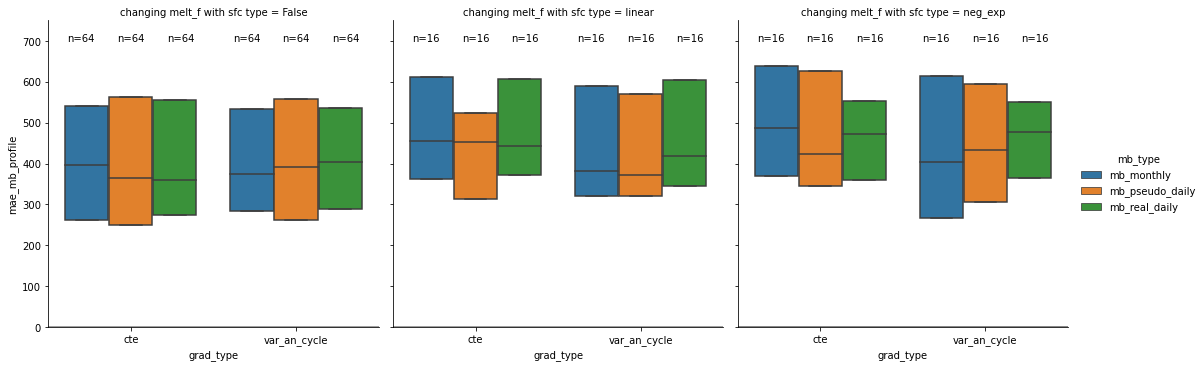

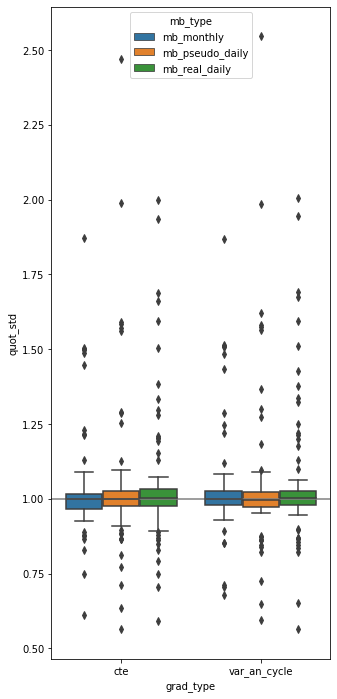

In [292]:
plt.figure(figsize=(5,12))
sns.boxplot(y='quot_std', hue='mb_type', data = pd_calib_opt_quot_std, x = 'grad_type') #, whis=False, fliersize=0)
plt.axhline([1], color = 'grey')
#plt.ylim([0.6,1.4])

**validation check:**

In [582]:
sfc_type = False

(200.0, 700.0)

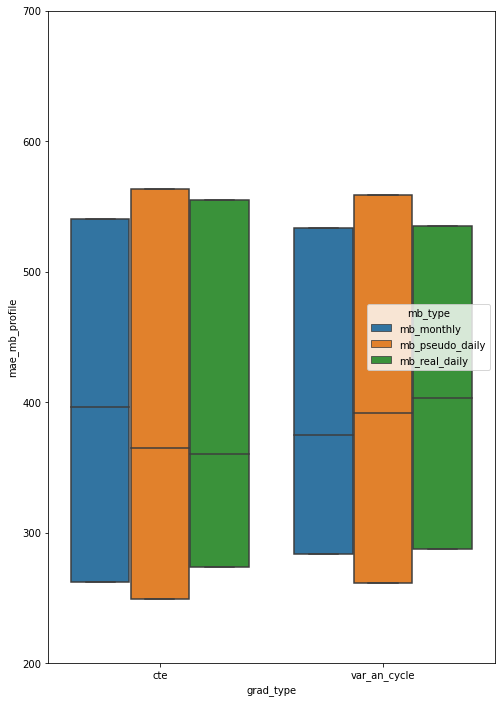

In [584]:

pd_calib_opt_quot_std_pre_sel = pd_calib_opt_quot_std.loc[pd_calib_opt_quot_std['changing melt_f with sfc type'] == sfc_type]
plt.figure(figsize=(8,12))
sns.boxplot(y='mae_mb_profile', hue='mb_type', data = pd_calib_opt_quot_std_pre_sel, x = 'grad_type', whis=False,
            fliersize=0)
plt.ylim([200,700])
#plt.axhline([1], color = 'grey')


In [587]:
corr_spearman = {}
for sfc_type in [False, 'linear', 'neg_exp']:

    pd_calib_opt_quot_std_sel = pd_calib_opt_quot_std.loc[pd_calib_opt_quot_std['changing melt_f with sfc type'] == sfc_type]
    for grad_type in pd_calib_opt_quot_std_sel.grad_type.unique():
        pd_calib_sel = pd_calib_opt_quot_std_sel.loc[pd_calib_opt_quot_std_sel.grad_type == grad_type]
        for mb_type in pd_calib_sel.mb_type.unique():

            pd_calib_opt_quot_std_sel_sel = pd_calib_sel.loc[pd_calib_sel.mb_type == mb_type]

            corr_spearman[f'sfc_type_distinction_{sfc_type}_{grad_type}_{mb_type}'] = scipy.stats.spearmanr(pd_calib_opt_quot_std_sel_sel.winter_prcp_mean_no_pf,
                     pd_calib_opt_quot_std_sel_sel.pf_opt)
        

In [598]:
corr_spearman

{'sfc_type_distinction_False_cte_mb_monthly': SpearmanrResult(correlation=-0.4601293837248894, pvalue=5.715725723084983e-06),
 'sfc_type_distinction_False_cte_mb_pseudo_daily': SpearmanrResult(correlation=-0.44374550453885275, pvalue=1.3273558814502403e-05),
 'sfc_type_distinction_False_cte_mb_real_daily': SpearmanrResult(correlation=-0.39274770173646584, pvalue=0.00014068426866510755),
 'sfc_type_distinction_False_var_an_cycle_mb_monthly': SpearmanrResult(correlation=-0.3724719101123596, pvalue=0.00032505244711978726),
 'sfc_type_distinction_False_var_an_cycle_mb_pseudo_daily': SpearmanrResult(correlation=-0.3693224378617637, pvalue=0.00036843179243835984),
 'sfc_type_distinction_False_var_an_cycle_mb_real_daily': SpearmanrResult(correlation=-0.32516172965611173, pvalue=0.0018762190654336081),
 'sfc_type_distinction_linear_cte_mb_monthly': SpearmanrResult(correlation=-0.8382352941176471, pvalue=5.010342100683478e-05),
 'sfc_type_distinction_linear_cte_mb_pseudo_daily': SpearmanrResult

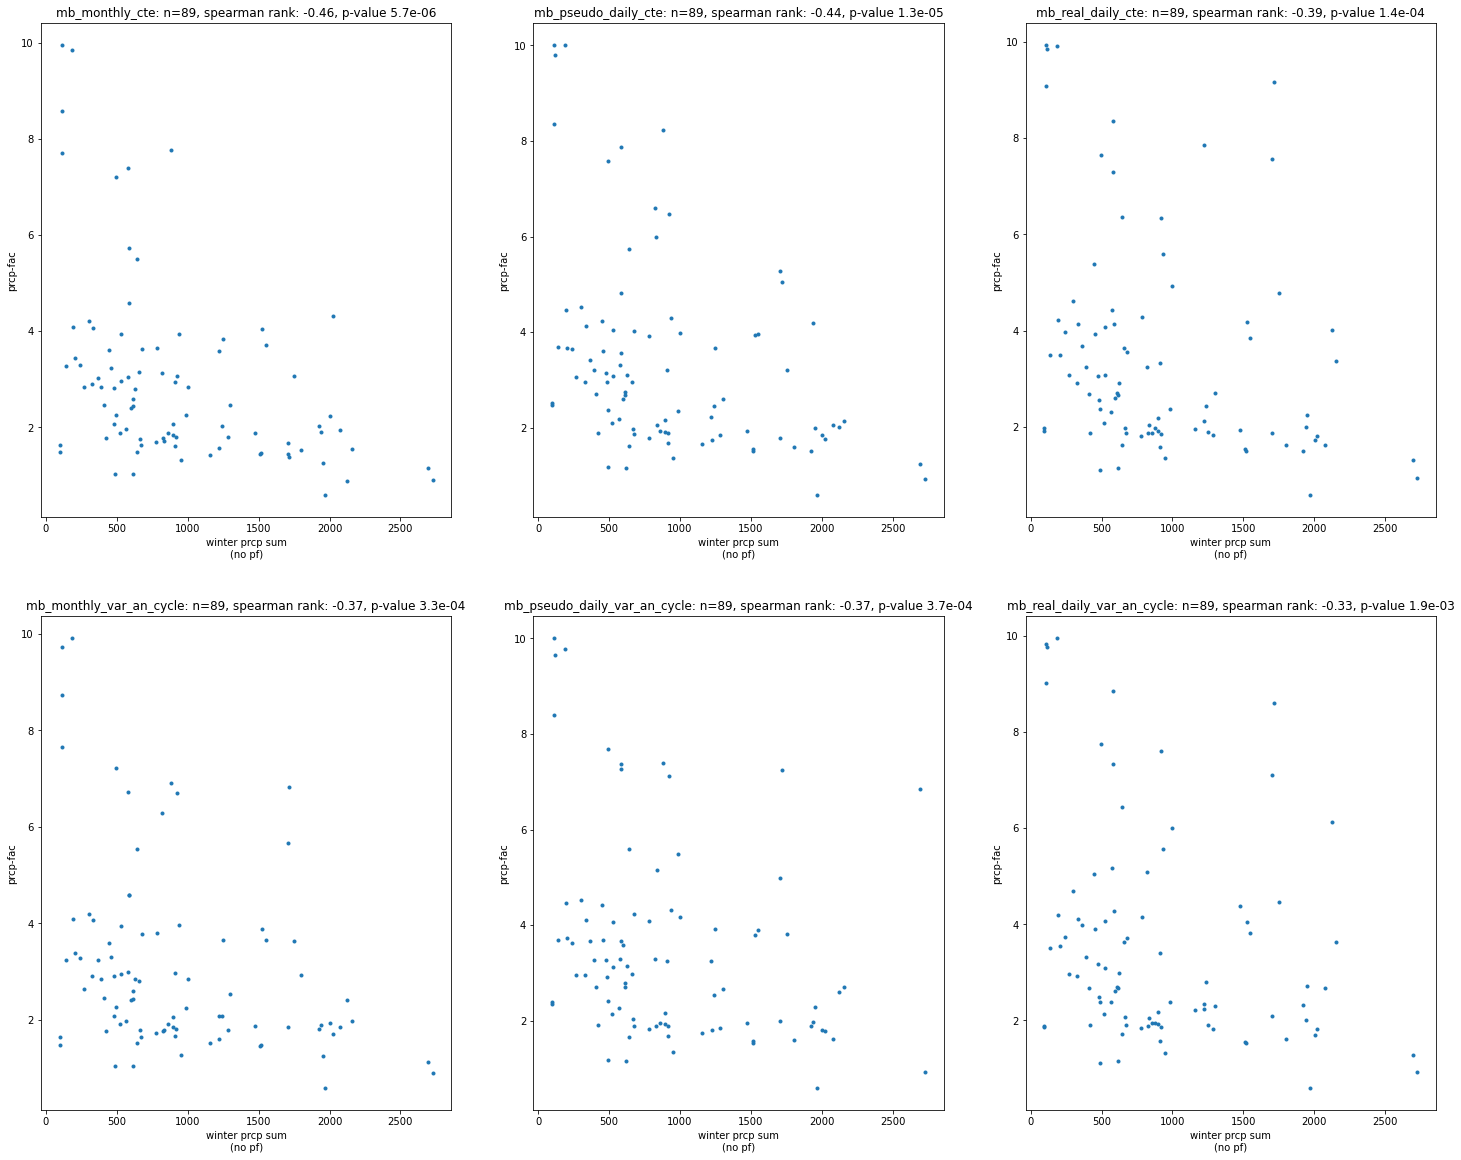

In [597]:
sfc_type = False
pd_calib_opt_quot_std_pre_sel = pd_calib_opt_quot_std.loc[pd_calib_opt_quot_std['changing melt_f with sfc type'] == sfc_type]

plt.figure(figsize=(25,20))
j = 0
for grad_type in pd_calib_opt_quot_std.grad_type.unique():
    pd_calib_sel = pd_calib_opt_quot_std_pre_sel.loc[pd_calib_opt_quot_std_pre_sel.grad_type == grad_type]
    for mb_type in pd_calib_opt_quot_std.mb_type.unique():

        j += 1
        plt.subplot(2,3,j)
        pd_calib_sel_sel = pd_calib_sel.loc[pd_calib_sel.mb_type == mb_type]
        #print(pd_calib_sel_sel.pf_opt.median())
        plt.plot(pd_calib_sel_sel.winter_prcp_mean_no_pf,
                 pd_calib_sel_sel.pf_opt, '.')
        c, p = corr_spearman[f'sfc_type_distinction_{sfc_type}_{grad_type}_{mb_type}']
        plt.title(f'{mb_type}_{grad_type}: n={len(pd_calib_sel_sel.pf_opt.dropna())}, spearman rank: {c.round(2)}, p-value {p:0.1e}')
        plt.xlabel('winter prcp sum\n(no pf)')
        plt.ylabel('prcp-fac')

0.0
0.5
-0.5
0.5
0.5
0.0


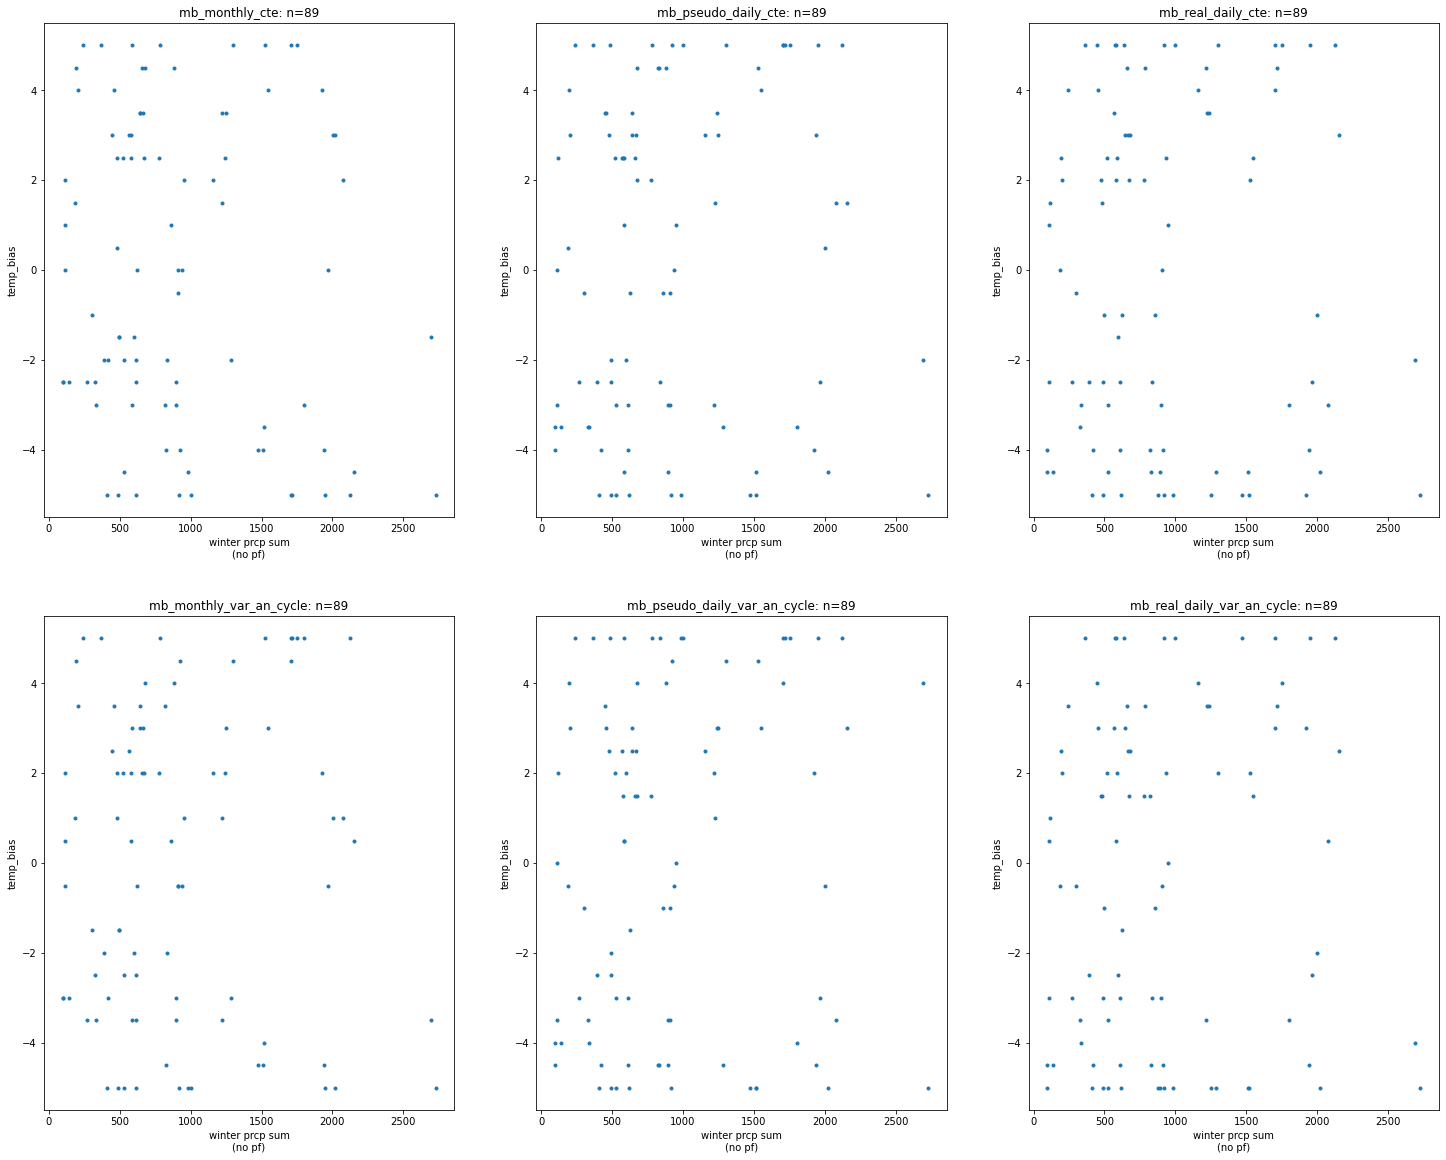

In [299]:
plt.figure(figsize=(25,20))
j = 0
for grad_type in pd_calib_opt_quot_std.grad_type.unique():
    pd_calib_sel = pd_calib_opt_quot_std.loc[pd_calib_opt_quot_std.grad_type == grad_type]
    for mb_type in pd_calib_opt_quot_std.mb_type.unique():

        j += 1
        plt.subplot(2,3,j)
        pd_calib_sel_sel = pd_calib_sel.loc[pd_calib_sel.mb_type == mb_type]
        print(pd_calib_sel_sel.temp_bias.median())

        plt.plot(pd_calib_sel_sel.winter_prcp_mean_no_pf,
                 pd_calib_sel_sel.temp_bias, '.')
        plt.title(f'{mb_type}_{grad_type}: n={len(pd_calib_sel_sel.pf_opt.dropna())}')
        plt.xlabel('winter prcp sum\n(no pf)')
        plt.ylabel('temp_bias')

In [599]:
corr_spearman_winter_solid_prcp = {}
for sfc_type in [False, 'linear', 'neg_exp']:

    pd_calib_opt_quot_std_sel = pd_calib_opt_quot_std.loc[pd_calib_opt_quot_std['changing melt_f with sfc type'] == sfc_type]
    for grad_type in pd_calib_opt_quot_std_sel.grad_type.unique():
        pd_calib_sel = pd_calib_opt_quot_std_sel.loc[pd_calib_opt_quot_std_sel.grad_type == grad_type]
        for mb_type in pd_calib_sel.mb_type.unique():

            pd_calib_opt_quot_std_sel_sel = pd_calib_sel.loc[pd_calib_sel.mb_type == mb_type]

            corr_spearman[f'sfc_type_distinction_{sfc_type}_{grad_type}_{mb_type}'] = scipy.stats.spearmanr(pd_calib_opt_quot_std_sel_sel.winter_solid_prcp_mean_no_pf,
                     pd_calib_opt_quot_std_sel_sel.pf_opt)
        

1.0
1.5
2.0
1.0
1.5
1.5


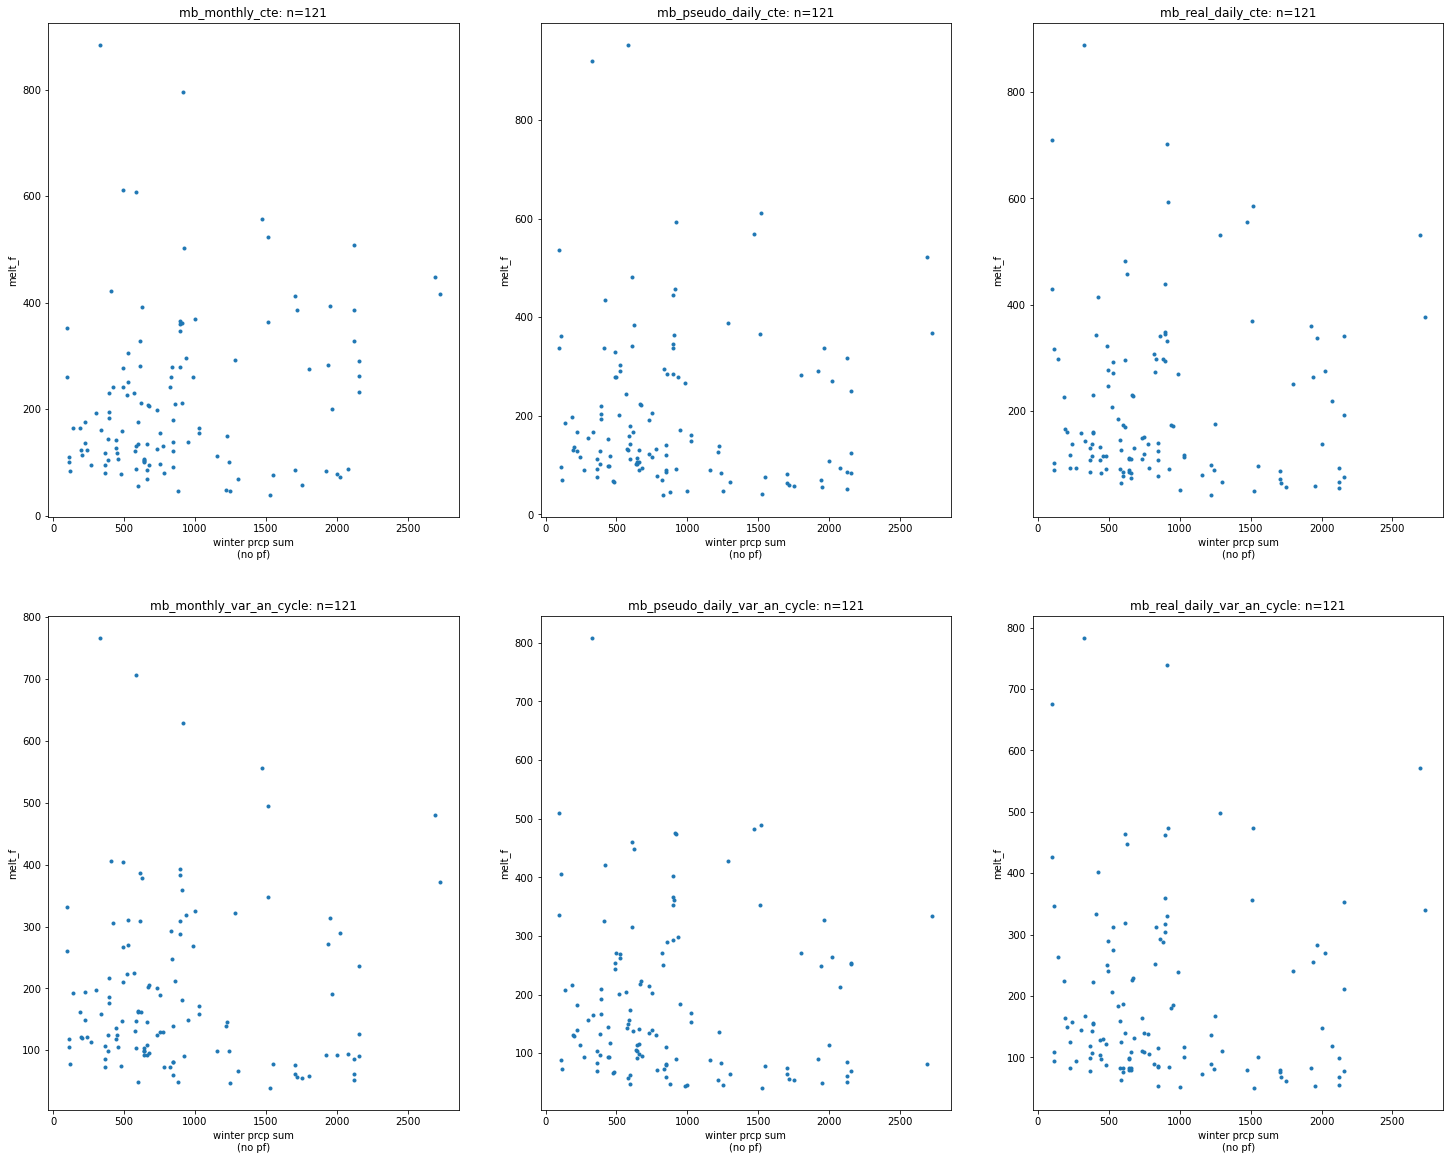

In [602]:
plt.figure(figsize=(25,20))
j = 0
for grad_type in pd_calib_opt_quot_std.grad_type.unique():
    pd_calib_sel = pd_calib_opt_quot_std.loc[pd_calib_opt_quot_std.grad_type == grad_type]
    for mb_type in pd_calib_opt_quot_std.mb_type.unique():

        j += 1
        plt.subplot(2,3,j)
        pd_calib_sel_sel = pd_calib_sel.loc[pd_calib_sel.mb_type == mb_type]
        print(pd_calib_sel_sel.temp_bias.median())

        plt.plot(pd_calib_sel_sel.winter_prcp_mean_no_pf,
                 pd_calib_sel_sel.melt_f, '.')
        plt.title(f'{mb_type}_{grad_type}: n={len(pd_calib_sel_sel.pf_opt.dropna())}')
        plt.xlabel('winter prcp sum\n(no pf)')
        plt.ylabel('melt_f')

#### Correlation with winter solid precipitation

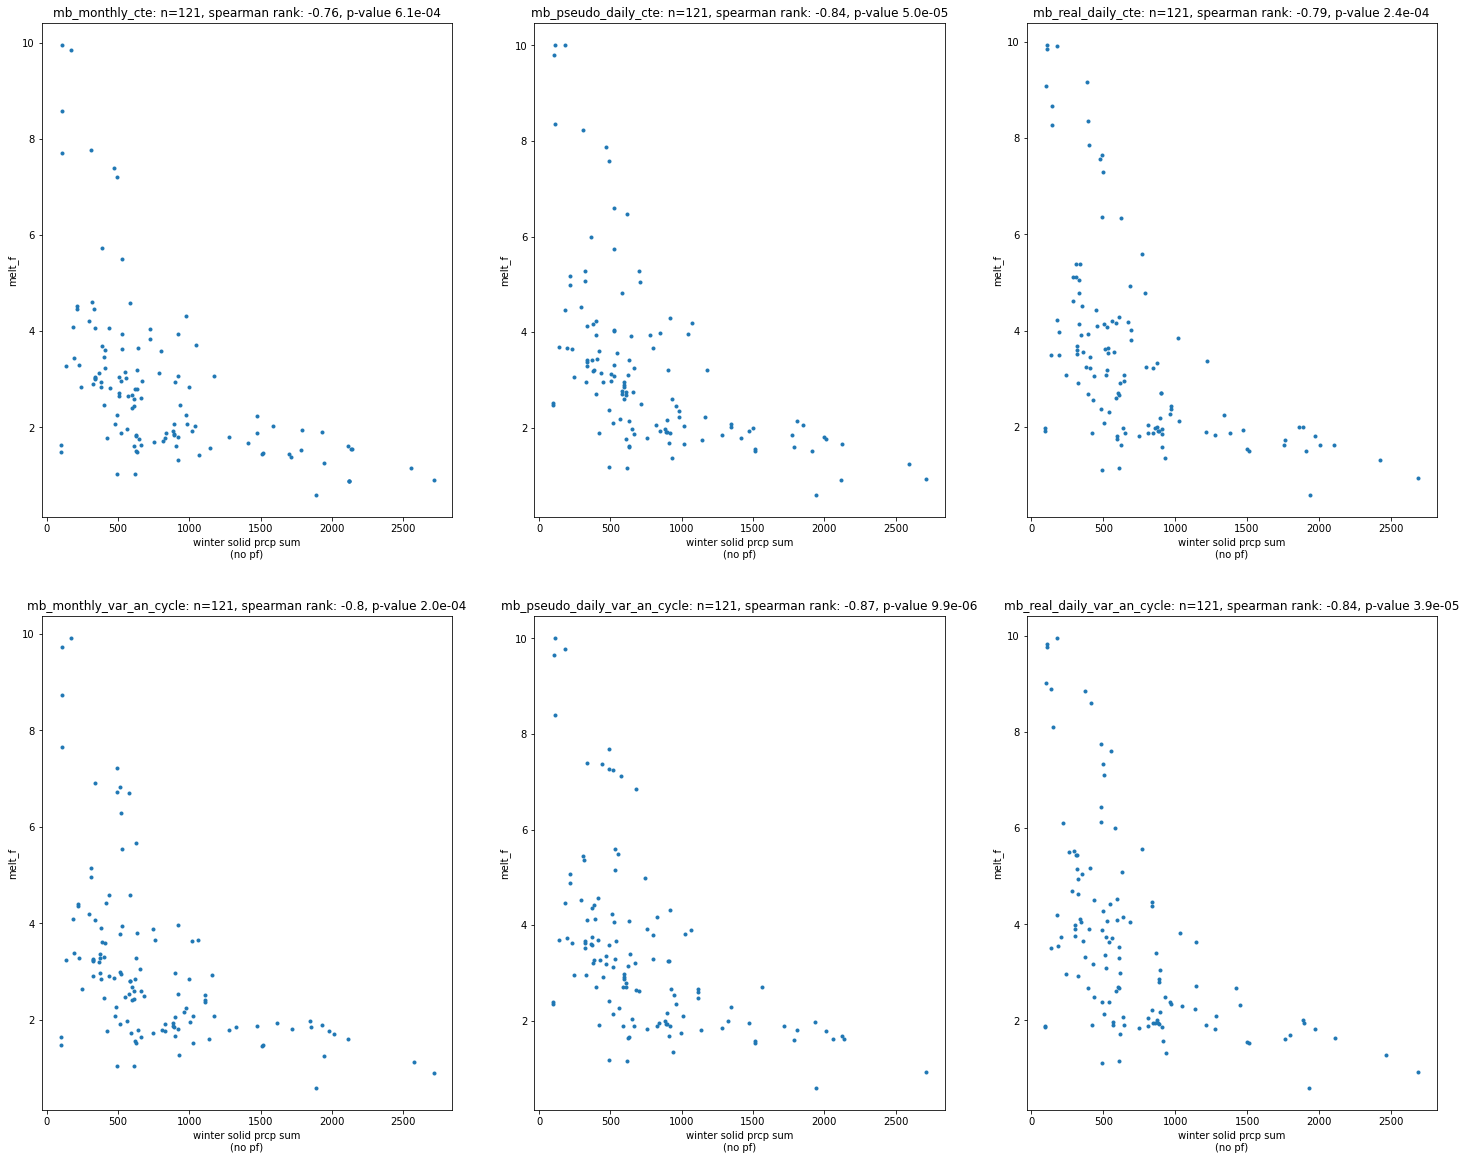

In [601]:
plt.figure(figsize=(25,20))
j = 0
for grad_type in pd_calib_opt_quot_std.grad_type.unique():
    pd_calib_sel = pd_calib_opt_quot_std.loc[pd_calib_opt_quot_std.grad_type == grad_type]
    for mb_type in pd_calib_opt_quot_std.mb_type.unique():

        j += 1
        plt.subplot(2,3,j)
        pd_calib_sel_sel = pd_calib_sel.loc[pd_calib_sel.mb_type == mb_type]

        plt.plot(pd_calib_sel_sel.winter_solid_prcp_mean_no_pf,
                 pd_calib_sel_sel.pf_opt, '.')
        
        c, p = corr_spearman[f'sfc_type_distinction_{sfc_type}_{grad_type}_{mb_type}']
        plt.title(f'{mb_type}_{grad_type}: n={len(pd_calib_sel_sel.pf_opt.dropna())}, spearman rank: {c.round(2)}, p-value {p:0.1e}')
        plt.xlabel('winter solid prcp sum\n(no pf)')
        plt.ylabel('melt_f')

Text(0.5, 0, 'difference in optimal temp. bias between MB types')

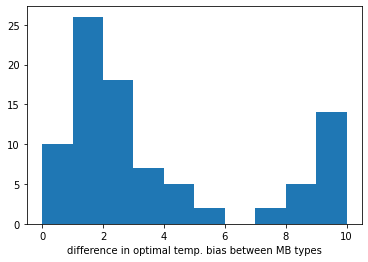

In [412]:
diff_opt_temp_bias = []
for rgi in pd_calib_opt_quot_std.rgi_id.unique():
    t = pd_calib_opt_quot_std.loc[pd_calib_opt_quot_std.rgi_id == rgi].temp_bias
    diff_opt_temp_bias.append(t.max() - t.min())
plt.hist(diff_opt_temp_bias)
plt.xlabel('difference in optimal temp. bias between MB types')